# A Cybersecurity Analysis of the National Vulnerability Database Using k-means Clustering

A rash of recent cybersecurity incidents impacting both the United States Government and private sector have illustrated the importance of maintaining strong defenses and proper hygiene practices. In one of the more notable recent cases, hackers stole the [Social Security numbers, birth dates, and addresses for more than 140 million Americans]( https://www.washingtonpost.com/business/technology/equifax-hack-hits-credit-histories-of-up-to-143-million-americans/2017/09/07/a4ae6f82-941a-11e7-b9bc-b2f7903bab0d_story.html?utm_term=.6354ae66cfc7) during a breach of the credit reporting firm Equifax. Although it has [since recovered substantially]( https://www.marketwatch.com/story/the-equifax-data-breach-in-one-chart-2018-09-07), the company’s [stock fell sharply]( https://www.marketwatch.com/story/equifax-breach-risks-143-million-americans-data-stock-plunges-13-2017-09-07) after the news became public, and its chief executive resigned under pressure and eventually found himself [testifying in front of the U.S. Congress]( https://money.cnn.com/2017/10/03/news/companies/equifax-ceo-congress/index.html).

More broadly, efforts to identify the total damage from intentional cyber attacks have revealed surprising numbers. For example, the White House Council of Economic Advisors estimates that malicious cyber activity in 2016 cost the United States economy between [57 billion and 109 billion dollars]( https://www.whitehouse.gov/articles/cea-report-cost-malicious-cyber-activity-u-s-economy/). Other estimates have put the annual global cost of cybercrime [600 billion dollars](https://www.csis.org/analysis/economic-impact-cybercrime).

A key repository of information regarding the vulnerabilities that allow intruders to breach computer networks is the National Vulnerability Database (NVD). The NVD is a product of the U.S. National Institute of Standards and Technology's (NIST) [Computer Security Division](https://csrc.nist.gov/) and is also sponsored by the U.S. Department of Homeland Security’s [Computer Emergency Readiness Team (US-CERT)]( https://www.us-cert.gov/).

Given that this rich dataset is available online for public use, I have analyzed it in an effort to identify what patterns, if any, there are to be found in recently detected cybersecurity vulnerabilities. Additionally, due to the relative wealth of information available regarding the aforementioned Equifax data breach, as well as the immediate and dire consequences of the incident, I will use it as a case study to highlight salient points throughout this analysis. For the purpose of this project, I will examine the NVD data from the year prior to the identification of the breach used in the Equifax hack. My model, however, is flexible enough to apply to other incidents and time periods. 

I have examined the relevant data to identify what types of vulnerabilities result in the greatest potential risk to enterprises. Although there are many different metrics by which to evaluate a cybersecurity vulnerability, I will use the [Common Vulnerability Scoring System (CVSS) v3.0 standards](https://nvd.nist.gov/vuln-metrics/cvss#) as my benchmark. This is mainly due to the fact that they are numerical variables on an easy-to-interpret 0-10 scale. Additionally, and unless otherwise stated, I will use the "base" CVSS 3.0 score as the proxy for severity. The "base" score is a function of the "impact" and "exploitability" [sub-score equations](https://nvd.nist.gov/vuln-metrics/cvss/v3-calculator).

In terms of analytical techniques, I plan to first identify the [Common Weakness Enumeration (CWE)](https://nvd.nist.gov/vuln/categories) codes associated with the highest CVSS 3.0 base scores. This will allow me to determine which types of vulnerabilities are the most concerning. Once that is complete, I will use an unsupervised learning technique called k-means clustering to identify any patterns in the data that might not be immediately apparent from my initial analysis. [Unsupervised learning](https://www.mathworks.com/discovery/unsupervised-learning.html) techniques represent a subset of machine learning algorithms used to draw inferences from datasets consisting of input data without labeled outputs. Unlike with supervised learning techniques, we do not know from the outset what target variable we are seeking to examine, but rather are allowing the algorithm to arrange data in ways that might elucidate useful patterns.

I will make a major disclaimer up front, however, regarding the potential bias of the data set. Since these incidents only reflect vulnerabilities identified and reported to the NVD, it is quite possible that the analysis below only incorporates a small fraction of the total universe of vulnerabilities. It is impossible to know the full extent of cybersecurity vulnerabilities or whether the NVD is even representative of them. With that being said, I still believe it is useful to examine the available data to determine if any useful trends can be identified. Furthermore, as I will show, understanding the relative gravity of a newly-discovered vulnerability can help leaders prioritize their response effort, potentially forestalling catastrophic events like the Equifax hack.

By applying statistical, graphical, and machine learning techniques to the NVD, I have also confirmed a relatively banal conclusion that is nonetheless important: the most dangerous vulnerabilities in cyber defenses are often the result of easily-remedied human error. Structured Query Language (SQL) and command injection attack vectors, along with poor credential management, are both common and potentially dangerous. For enterprises, identifying the practices that produce these vulnerabilities, and then eliminating them, are important steps towards stemming the increasingly powerful tide of cyber attacks.

#### A note on sources and documentation

Whenever I have paraphrased or directly quoted another author, I have employed embedded hyperlinks to refer directly to the original information. I have similarly used markdown text following blocks of code from which I have borrowed in part or in whole. Additionally, I have made frequent use of the [pandas](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/), [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/), and [scikit-learn](http://scikit-learn.org/stable/) documentation for help in using the various built-in functions for those libraries. Finally, I have used in-line commenting (indicated by lines beginning with a "#") in order to explain what the code in question is doing.

## Part 1 - Data loading, cleaning, and wrangling

In [1]:
# Pandas and NumPy are very useful Python library for data manipulation, cleaning, and analysis.
import pandas as pd
import numpy as np
# Here, I have disabled a false alarm that would otherwise trip later in the project.
pd.options.mode.chained_assignment = None

# The datetime library will let me filter the data by reporting date.
from datetime import datetime, timedelta

# Requests and urlopen will also allow me to access the NVD data from the NIST web site.
import requests
from urllib.request import urlopen

# Using zipfile and BytesIO is how I will decompress and access the actual NVD data.
from io import BytesIO
from zipfile import ZipFile

# Since the NVD data is housed in JavaScript Object Notation (JSON) format, I will need the json_normalize function to access and manipulate the information.
from pandas.io.json import json_normalize

In [2]:
# Expanding view area to facilitate data manipulation.
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

In [3]:
# I will later use the below date in order to filter the data so that it only contains vulnerabilities reported before a specific cyber event.
cutoff_date = pd.to_datetime('2017-03-12')
# The below specifies how many days before the incident the model should stop incorporating NVD events.
time_interval = 365
start_date = cutoff_date - timedelta(days=time_interval)

# I am using a cutoff date of March 12, 2017 because, although US-CERT released its alert regarding the vulnerability used in the Equifax Hack on March 8, the entry in the NVD did not appear until March 11.

# The below years signify which years of NVD data I will use.
years = [2016, 2017]

In [4]:
# Accessing and unzipping the data, and storing it in a pandas data frame.
counter = 0
df = []

for year in years:
    url = 'https://nvd.nist.gov/feeds/json/cve/1.0/nvdcve-1.0-'+str(year)+'.json.zip'
    extract_target = 'nvdcve-1.0-'+str(year)+'.json'
    # Extracting zip file
    z = urlopen(url)
    stage_1 = z.read()
    stage_2 = (BytesIO(stage_1))
    stage_3 = ZipFile(stage_2)
    stage_4 = stage_3.extract(extract_target)
    yearly_data = pd.read_json(stage_4)
    if counter == 0:
        df = yearly_data
    else:
        df = df.append(yearly_data)
    counter +=1
    print(year)
    print('complete')

2016
complete
2017
complete


I used code from three stackoverflow posts to assist in [downloading](https://stackoverflow.com/questions/5710867/downloading-and-unzipping-a-zip-file-without-writing-to-disk), [unzipping, reading](https://stackoverflow.com/questions/18885175/read-a-zipped-file-as-a-pandas-dataframe), and [normalizing](https://stackoverflow.com/questions/45325208/python-json-normalize-a-pandas-series-gives-typeerror) the JSON files on the NVD web site.

In [5]:
# Flatenning CVE_Items
CVE_Items = json_normalize(df["CVE_Items"])

In [6]:
# Concatenating and cleaning up the data frame by dropping the original index as well as the nested JSON column
df = pd.concat([df.reset_index(), CVE_Items], axis=1)
df = df.drop(["index", "CVE_Items"], axis=1)

In [7]:
len(df["cve.CVE_data_meta.ID"].unique())

25031

Evaluating the "cve.CVE_data_meta.ID" column, I can determine that there are 15,067 unique recorded incidents from 2017. This matches the number for the column "CVE_data_numberOfCVEs."

In [8]:
df = df.rename(columns={"cve.CVE_data_meta.ID": "CVE ID"})
CVE_ID = df["CVE ID"]
df.drop(labels=["CVE ID"], axis=1,inplace = True)
df.insert(0, "CVE ID", CVE_ID)

I used the this [stackoverflow post](https://stackoverflow.com/questions/25122099/move-column-by-name-to-front-of-table-in-pandas) to assist in re-ordering the CVE ID column.

Checking for null values, I see that there are a substantial number of them in the dataset. In fact, a majority contain some null values.

In [9]:
len(df[df.isnull().any(axis=1)])

22365

A manual review reveals that the "impact.baseMetricV2.acInsufInfo" has many null values, so I will examine the data set to determine how may entries have null values in this columm.

In [10]:
len(df[df["impact.baseMetricV2.acInsufInfo"].isnull()])

22265

In [11]:
df = df.drop(["impact.baseMetricV2.acInsufInfo"], axis=1)

Since there are so many null values in this column, I will drop it. After doing so, however, I still have some null values left.

In [12]:
len(df[df.isnull().any(axis=1)])

3437

In [13]:
df[df.isnull().any(axis=1)].head()

,CVE ID,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,configurations.CVE_data_version,configurations.nodes,cve.CVE_data_meta.ASSIGNER,cve.affects.vendor.vendor_data,cve.data_format,cve.data_type,cve.data_version,cve.description.description_data,cve.problemtype.problemtype_data,cve.references.reference_data,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.vectorString,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,lastModifiedDate,publishedDate
0,CVE-2016-0001,CVE,MITRE,4,9871,2019-02-07T08:26Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
3,CVE-2016-0004,CVE,MITRE,4,9871,2019-02-07T08:26Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
12,CVE-2016-0013,CVE,MITRE,4,9871,2019-02-07T08:26Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
13,CVE-2016-0014,CVE,MITRE,4,9871,2019-02-07T08:26Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'Microsoft Windows Vi...","[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'http://www.securitytracker.com/id/10...,MEDIUM,LOCAL,NONE,COMPLETE,6.9,COMPLETE,COMPLETE,AV:L/AC:M/Au:N/C:C/I:C/A:C,2.0,3.4,10.0,False,False,False,MEDIUM,NaN,LOW,LOCAL,HIGH,7.8,HIGH,HIGH,HIGH,LOW,UNCHANGED,NONE,CVSS:3.0/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,3.0,1.8,5.9,2018-10-30T16:27Z,2016-01-13T05:59Z
15,CVE-2016-0016,CVE,MITRE,4,9871,2019-02-07T08:26Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'Microsoft Windows Vi...","[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'http://www.securitytracker.com/id/10...,MEDIUM,LOCAL,NONE,COMPLETE,6.9,COMPLETE,COMPLETE,AV:L/AC:M/Au:N/C:C/I:C/A:C,2.0,3.4,10.0,False,False,False,MEDIUM,NaN,LOW,LOCAL,HIGH,7.8,HIGH,HIGH,HIGH,LOW,UNCHANGED,NONE,CVSS:3.0/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,3.0,1.8,5.9,2018-10-30T16:27Z,2016-01-13T05:59Z


Drilling down more closely on the first entry with null values, it appears that it is an erroneous entry and does not actually represent a security issue.

In [14]:
df[df.isnull().any(axis=1)].iloc[0]["cve.description.description_data"]

[{'lang': 'en',
  'value': '** REJECT **  DO NOT USE THIS CANDIDATE NUMBER. ConsultIDs: none. Reason: The CNA or individual who requested this candidate did not associate it with any vulnerability during 2016. Notes: none.'}]

Evaluating all of the rows containing null entries, I see the vast majority of them contain the word "reject."

In [15]:
y = 0
for x in df["cve.description.description_data"]:
#    print((json_normalize(x)["value"])[0])
    if "REJECT" in (json_normalize(x)["value"])[0]:
        y+=1
    else:
        y
print(y)

2680


Since most of these entries containing null values seem erroneous, it seems fair to drop all of them, which I do below:

In [16]:
df = df.dropna(axis=0)

Finally, I am going to use the cutoff date from above to filter the entries by date. I used this [stackoverflow](https://stackoverflow.com/questions/22898824/filtering-pandas-dataframes-on-dates) post as a guide.

In [17]:
# Converting the data to pandas date-time format
df["publishedDate"] = pd.to_datetime(df["publishedDate"])

In [18]:
df = df[(df["publishedDate"] < cutoff_date) & (df["publishedDate"] > start_date)]

Drilling down into the "cve.problemtype.problemtype_data" column, I can see the CWE codes are embedded within JSON objects.

In [19]:
df["cve.problemtype.problemtype_data"].head(1).values[0]

[{'description': [{'lang': 'en', 'value': 'CWE-20'}]}]

Thus, I need to flatten the JSON file further to extract the "primary" (i.e. listed first) and "secondary" (listed second, if applicable) CWE codes for each incident.

In [20]:
# Extracting the CWE codes from "cve.problemtype.problemtype_data"
# Creating empty list for 1st CWE code
CWE_entry_1 = []
# Isolating index so that all values align properly
CWE_index = df["cve.problemtype.problemtype_data"].index

# Running a "for" loop in order to extract and normalize the information contained with the JSON structure.
for x in df["cve.problemtype.problemtype_data"]:
    CWE_normalized_json_step_1 = json_normalize(x)
    CWE_normalized_json_step_2 = CWE_normalized_json_step_1["description"][0]
    raw_CWE_entry = json_normalize(CWE_normalized_json_step_2)["value"][0]
    clean_CWE_entry = str(raw_CWE_entry)
    # Adding 1st CWE code
    CWE_entry_1.append(clean_CWE_entry)
    
CWE_entry_1 = pd.Series(CWE_entry_1, index = CWE_index)

In [21]:
# Creating empty list for 2nd CWE code
CWE_entry_2 = []

for x in df["cve.problemtype.problemtype_data"]:
    try:
        CWE_normalized_json_step_1 = json_normalize(x)
        CWE_normalized_json_step_2 = CWE_normalized_json_step_1["description"][0]
        raw_CWE_entry = json_normalize(CWE_normalized_json_step_2)["value"][1]
        clean_CWE_entry = str(raw_CWE_entry)
        CWE_entry_2.append(clean_CWE_entry)
        # adding 2nd CWE code
    
    except:
        CWE_entry_2.append("NONE")
        # creating a "NONE" label if secondary CWE code is not available

CWE_entry_2 = pd.Series(CWE_entry_2, index = CWE_index)

In [22]:
# Merging two series of CWE codes
df_CWE = pd.concat([CWE_entry_1, CWE_entry_2], axis=1)
# Renaming the columns
df_CWE.columns = ["CWE Code 1", "CWE Code 2"]

In [23]:
# Identifying all the unique primary CWE codes
CWE_entry_1.unique()

array(['CWE-20', 'CWE-119', 'CWE-200', 'CWE-254', 'CWE-264', 'CWE-19',
       'CWE-284', 'NVD-CWE-Other', 'CWE-601', 'CWE-79', 'CWE-89',
       'CWE-77', 'CWE-399', 'CWE-611', 'CWE-532', 'NVD-CWE-noinfo',
       'CWE-78', 'CWE-255', 'CWE-502', 'CWE-352', 'CWE-275', 'CWE-693',
       'CWE-189', 'CWE-287', 'CWE-310', 'CWE-285', 'CWE-327', 'CWE-362',
       'CWE-94', 'CWE-295', 'CWE-22', 'CWE-426', 'CWE-320', 'CWE-476',
       'CWE-125', 'CWE-388', 'CWE-17', 'CWE-416', 'CWE-190', 'CWE-326',
       'CWE-798', 'CWE-74', 'CWE-787', 'CWE-338', 'CWE-384', 'CWE-59',
       'CWE-297', 'CWE-361', 'CWE-191', 'CWE-345', 'CWE-640', 'CWE-116',
       'CWE-434', 'CWE-91', 'CWE-358', 'CWE-415', 'CWE-369', 'CWE-172',
       'CWE-918', 'CWE-427', 'CWE-704', 'CWE-93', 'CWE-669', 'CWE-330',
       'CWE-113', 'CWE-199', 'CWE-428', 'CWE-400', 'CWE-184', 'CWE-18',
       'CWE-682', 'CWE-749', 'CWE-306', 'CWE-346', 'CWE-129', 'CWE-775',
       'CWE-332', 'CWE-90', 'CWE-417', 'CWE-485', 'CWE-99', 'CWE-134',
   

In [24]:
# Identifying all the unique secondary CWE codes
CWE_entry_2.unique()

array(['NONE', 'CWE-284', 'CWE-200', 'CWE-89', 'CWE-119', 'CWE-255',
       'CWE-254', 'CWE-264', 'CWE-190', 'CWE-362', 'CWE-399', 'CWE-287',
       'CWE-20', 'CWE-787', 'NVD-CWE-Other', 'CWE-189', 'CWE-310',
       'CWE-416', 'CWE-476', 'CWE-113', 'CWE-19', 'NVD-CWE-noinfo',
       'CWE-275', 'CWE-59', 'CWE-191', 'CWE-388'], dtype=object)

Since there are several entries for what is essentially the same thing (unknown CWE type), I am going to convert 'NVD-CWE-Other' and 'NVD-CWE-noinfo' to 'UNKNOWN'.

In [25]:
# Defining a function which I will use below
def consolidate_unknowns(x):
    if x == "NVD-CWE-Other" or x == "NVD-CWE-noinfo":
        return "UNKNOWN"
    else:
        return x

In [26]:
df_CWE = df_CWE.applymap(consolidate_unknowns)
CWE_entry_1 = CWE_entry_1.apply(consolidate_unknowns)
CWE_entry_2 = CWE_entry_2.apply(consolidate_unknowns)

In [27]:
# Merging CWE codes onto a master data frame
df_w_CWE_codes = df.join(df_CWE)

In [28]:
df_w_CWE_codes.head()

,CVE ID,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,configurations.CVE_data_version,configurations.nodes,cve.CVE_data_meta.ASSIGNER,cve.affects.vendor.vendor_data,cve.data_format,cve.data_type,cve.data_version,cve.description.description_data,cve.problemtype.problemtype_data,cve.references.reference_data,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.vectorString,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,lastModifiedDate,publishedDate,CWE Code 1,CWE Code 2
24,CVE-2016-0025,CVE,MITRE,4,9871,2019-02-07T08:26Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'Microsoft Word 2007 ...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securitytracker.com/id/10...,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,AV:N/AC:M/Au:N/C:C/I:C/A:C,2.0,8.6,10.0,False,False,False,HIGH,True,LOW,LOCAL,HIGH,7.3,HIGH,HIGH,HIGH,LOW,UNCHANGED,REQUIRED,CVSS:3.0/AV:L/AC:L/PR:L/UI:R/S:U/C:H/I:H/A:H,3.0,1.3,5.9,2018-10-12T22:10Z,2016-06-16 01:59:00,CWE-20,NONE
25,CVE-2016-0026,CVE,MITRE,4,9871,2019-02-07T08:26Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'The Common Log File ...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securityfocus.com/bid/939...,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,AV:N/AC:M/Au:N/C:C/I:C/A:C,2.0,8.6,10.0,False,False,False,HIGH,True,LOW,LOCAL,HIGH,7.8,HIGH,HIGH,HIGH,NONE,UNCHANGED,REQUIRED,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,3.0,1.8,5.9,2018-10-12T22:10Z,2016-11-10 06:59:00,CWE-119,NONE
27,CVE-2016-0028,CVE,MITRE,4,9871,2019-02-07T08:26Z,4.0,"[{'operator': 'AND', 'children': [{'operator':...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'Outlook Web Access (...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securitytracker.com/id/10...,MEDIUM,NETWORK,NONE,NONE,4.3,PARTIAL,NONE,AV:N/AC:M/Au:N/C:P/I:N/A:N,2.0,8.6,2.9,False,False,False,MEDIUM,True,LOW,LOCAL,NONE,5.5,MEDIUM,HIGH,NONE,NONE,UNCHANGED,REQUIRED,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,3.0,1.8,3.6,2018-10-12T22:10Z,2016-06-16 01:59:00,CWE-200,NONE
69,CVE-2016-0070,CVE,MITRE,4,9871,2019-02-07T08:26Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'The kernel in Micros...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securityfocus.com/bid/933...,MEDIUM,NETWORK,NONE,NONE,4.3,PARTIAL,NONE,AV:N/AC:M/Au:N/C:P/I:N/A:N,2.0,8.6,2.9,False,False,False,MEDIUM,True,LOW,LOCAL,NONE,5.5,MEDIUM,HIGH,NONE,NONE,UNCHANGED,REQUIRED,CV

Now that I have extracted all the CWE codes from the various incidents, I need to understand what each code means. Unfortunately, there is no database available from an Application Programming Interface (API) or via a JSON file. The NVD does, however, provide a structured table on its website, which I can scrape using the BeautifulSoup library for Python.

In [29]:
# Importing BeautifulSoup and an xml parser to scrape the CWE definitions from the NVD web site
from bs4 import BeautifulSoup
import lxml.etree

In [30]:
# loading the NVD CWE Definitions page and scraping it for the first table that appears
NVD_CWE_description_url = requests.get("https://nvd.nist.gov/vuln/categories")
CWE_definitions_page_soup =  BeautifulSoup(NVD_CWE_description_url.content, "html5lib")
table = CWE_definitions_page_soup.find_all('table')[0] 
df_CWE_definitions = pd.read_html(str(table))[0]

I used this [stackoverflow](https://stackoverflow.com/questions/4462061/beautiful-soup-to-parse-url-to-get-another-urls-data) post to assist in writing the above code.

In [31]:
df_CWE_definitions

,Name,CWE-ID,Description
0,CWE-824,Access of Uninitialized Pointer,The program accesses or uses a pointer that ha...
1,CWE-407,Algorithmic Complexity,An algorithm in a product has an inefficient w...
2,CWE-774,Allocation of File Descriptors or Handles With...,The software allocates file descriptors or han...
3,CWE-88,Argument Injection or Modification,The software does not sufficiently delimit the...
4,CWE-405,Asymmetric Resource Consumption (Amplification),Software that does not appropriately monitor o...
5,CWE-287,Authentication Issues,"When an actor claims to have a given identity,..."
6,CWE-119,Buffer Errors,The software performs operations on a memory b...
7,CWE-417,Channel and Path Errors,Weaknesses in this category are related to imp...
8,CWE-171,"Cleansing, Canonicalization, and Comparison Er...",Weaknesses in this category are related to imp...
9,CWE-17,Code,Weaknesses in this category are typically intr...


Now that I have collected the definitions of the various CWE codes, I will join them with my consolidated data frame.

In [32]:
# Adding the names and definitions for primary CWE codes
df_w_CWE_defs = df_w_CWE_codes.merge(df_CWE_definitions, how="left", left_on= "CWE Code 1", right_on = "Name")

In [33]:
# Renaming columns so they are more descriptive for 1st CWE Code, and dropping "Name" column since it is redundant
df_w_CWE_defs = df_w_CWE_defs.rename(columns={'CWE-ID': 'CWE Code 1 Name', 'Description': 'CWE Code 1 Description'})
df_w_CWE_defs = df_w_CWE_defs.drop(["Name"], axis=1)

In [34]:
# Adding the names and definitions for secondary CWE codes
df_w_CWE_defs = df_w_CWE_defs.merge(df_CWE_definitions, how="left", left_on= "CWE Code 2", right_on = "Name")

In [35]:
# Repeating the process for the second CWE code
df_w_CWE_defs = df_w_CWE_defs.rename(columns={'CWE-ID': 'CWE Code 2 Name', 'Description': 'CWE Code 2 Description'})
df_w_CWE_defs = df_w_CWE_defs.drop(["Name"], axis=1)

Below I have decided to finalize my cleaning of the data frame by dropping a variety of different columns which I do not plan on analyzing further (e.g. some of the CVSS 2.0 entries), or from which I have already extracted the necessary information (e.g. the CWE codes from "cve.problemtype.problemtype_data").

In [36]:
df_w_CWE_defs_cleaned = df_w_CWE_defs.drop(["CVE_data_type", "CVE_data_format", "cve.affects.vendor.vendor_data", "cve.problemtype.problemtype_data", "cve.description.description_data", "cve.references.reference_data", "CVE_data_version", "CVE_data_numberOfCVEs", "impact.baseMetricV2.cvssV2.vectorString", "impact.baseMetricV3.cvssV3.vectorString", "CVE_data_timestamp", "configurations.CVE_data_version", "configurations.nodes", "cve.CVE_data_meta.ASSIGNER", "cve.data_format", "cve.data_type", "cve.data_version", "lastModifiedDate", "publishedDate"], axis=1)

In [37]:
df_w_CWE_defs_cleaned.head()

,CVE ID,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,CWE Code 1,CWE Code 2,CWE Code 1 Name,CWE Code 1 Description,CWE Code 2 Name,CWE Code 2 Description
0,CVE-2016-0025,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,2.0,8.6,10.0,False,False,False,HIGH,True,LOW,LOCAL,HIGH,7.3,HIGH,HIGH,HIGH,LOW,UNCHANGED,REQUIRED,3.0,1.3,5.9,CWE-20,NONE,Input Validation,The product does not validate or incorrectly v...,NaN,NaN
1,CVE-2016-0026,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,2.0,8.6,10.0,False,False,False,HIGH,True,LOW,LOCAL,HIGH,7.8,HIGH,HIGH,HIGH,NONE,UNCHANGED,REQUIRED,3.0,1.8,5.9,CWE-119,NONE,Buffer Errors,The software performs operations on a memory b...,NaN,NaN
2,CVE-2016-0028,MEDIUM,NETWORK,NONE,NONE,4.3,PARTIAL,NONE,2.0,8.6,2.9,False,False,False,MEDIUM,True,LOW,LOCAL,NONE,5.5,MEDIUM,HIGH,NONE,NONE,UNCHANGED,REQUIRED,3.0,1.8,3.6,CWE-200,NONE,Information Leak / Disclosure,An information exposure is the intentional or ...,NaN,NaN
3,CVE-2016-0070,MEDIUM,NETWORK,NONE,NONE,4.3,PARTIAL,NONE,2.0,8.6,2.9,False,False,False,MEDIUM,True,LOW,LOCAL,NONE,5.5,MEDIUM,HIGH,NONE,NONE,UNCHANGED,REQUIRED,3.0,1.8,3.6,CWE-200,NONE,Information Leak / Disclosure,An information exposure is the intentional or ...,NaN,NaN
4,CVE-2016-0073,LOW,LOCAL,NONE,NONE,2.1,PARTIAL,NONE,2.0,3.9,2.9,False,False,False,LOW,False,LOW,LOCAL,NONE,5.0,MEDIUM,HIGH,NONE,LOW,UNCHANGED,REQUIRED,3.0,1.3,3.6,CWE-200,NONE,Information Leak / Disclosure,An information exposure is the intentional or ...,NaN,NaN


# Part 2 - Exploratory data analysis

In [38]:
import matplotlib.pyplot as plt
# matplotlib is another library for Python that is very powerful when creating data-rich graphics
plt.rcParams.update({'font.size': 16})
# Setting default font size
%matplotlib inline
# Ensuring the all my plots are inline and thus look better

Now that I have consolidated all of the various codes and definitions into one data frame, I can begin analyzing the information I have, both quantitatively and graphically. To start, I simply list all of the CWE codes by frequency, in descending order.

For primary CWE codes:

In [39]:
CWE_counts_1 = CWE_entry_1.value_counts().sort_values(axis=0, ascending=False)
CWE_counts_1

CWE-119    1188
UNKNOWN     732
CWE-200     696
CWE-284     644
CWE-264     625
CWE-79      571
CWE-20      500
CWE-125     183
CWE-399     180
CWE-254     163
           ... 
CWE-134       1
CWE-485       1
CWE-669       1
CWE-18        1
CWE-613       1
CWE-297       1
CWE-199       1
CWE-417       1
CWE-693       1
CWE-118       1
Length: 83, dtype: int64

Additionally, I have created a bar graph showing the relative frequency of appearance of the various primary CWE codes.

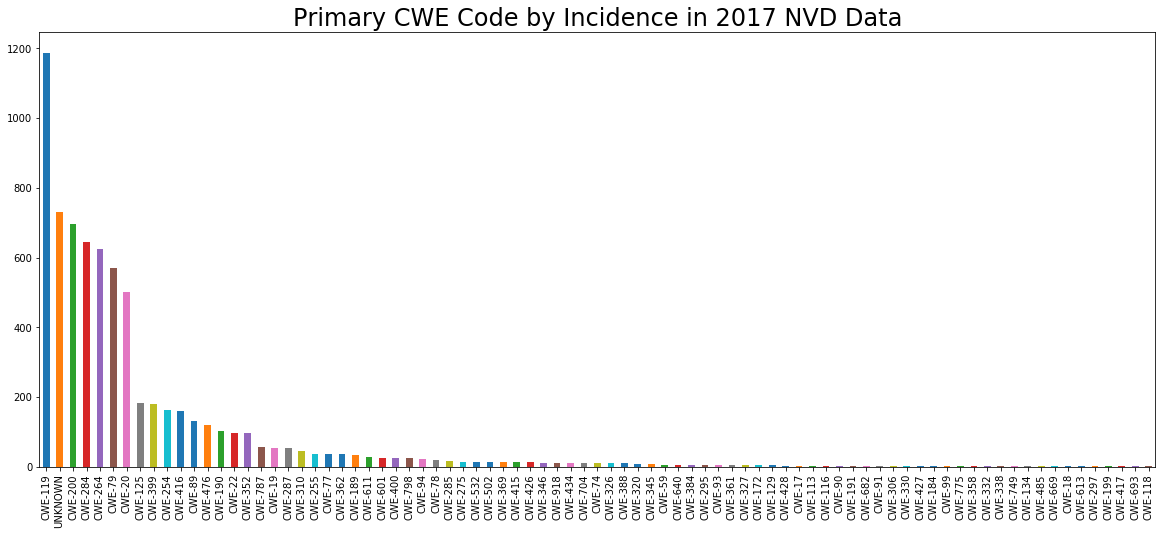

In [40]:
CWE_counts_1.plot(kind = "bar", figsize = (20,8))
plt.title("Primary CWE Code by Incidence in 2017 NVD Data", fontsize = 24)
plt.show();

Based on the above, I can see that some CWE codes are very common while others are quite rare. As a first step, I will examine the most common primary code, CWE-119, and its description.

In [41]:
CWE_119_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-119"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_119_info[0])
print(CWE_119_info[1])
print(CWE_119_info[2])

CWE-119
Buffer Errors
The software performs operations on a memory buffer, but it can read from or write to a memory location that is outside of the intended boundary of the buffer.


According the the [InfoSec Institute](https://resources.infosecinstitute.com/how-to-fix-the-top-five-cyber-security-vulnerabilities/#gref):
    
"A buffer overflow vulnerability condition exists when an application attempts to put more data in a buffer than it can hold. Hackers exploit buffer overflow vulnerabilities to overwrite the content of adjacent memory blocks causing data corruption, crash the program, or the execution of an arbitrary malicious code."

Having addressed the primary CWE codes, I will do the same for secondary ones.

In [42]:
CWE_counts_2 = CWE_entry_2.value_counts().sort_values(axis=0, ascending=False)
CWE_counts_2

NONE       6694
CWE-200      81
CWE-119      26
CWE-264      25
CWE-254      21
CWE-399      19
CWE-20       13
CWE-284      12
CWE-362      10
CWE-787       8
           ... 
CWE-189       4
CWE-287       3
UNKNOWN       3
CWE-59        2
CWE-388       2
CWE-275       2
CWE-19        2
CWE-416       1
CWE-191       1
CWE-113       1
Length: 25, dtype: int64

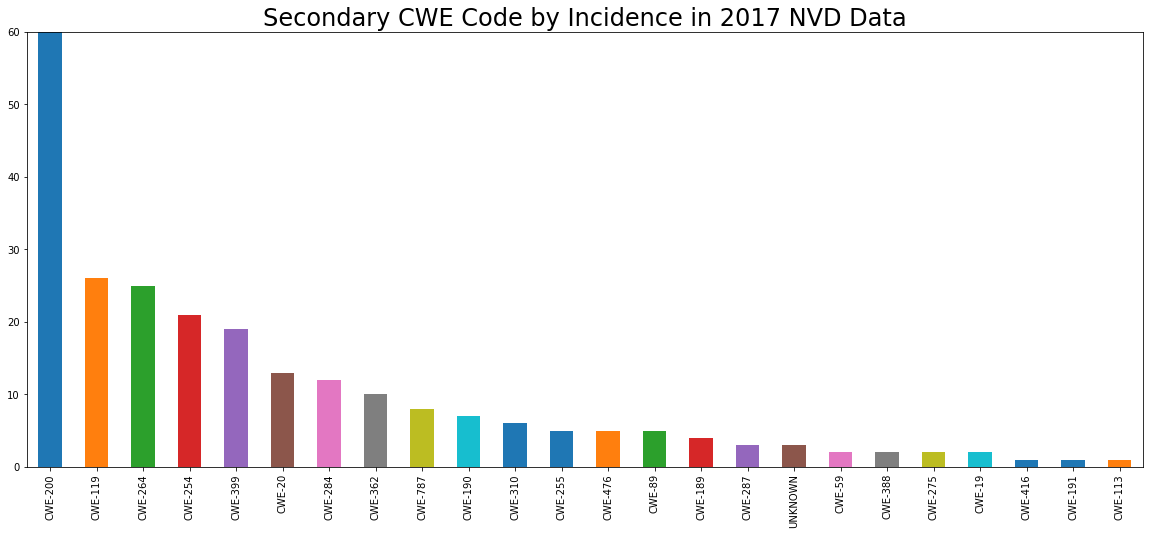

In [43]:
CWE_counts_2.drop("NONE").plot(kind = "bar", figsize = (20,8))
# I have dropped all CWE codes with the label "NONE," because they do not factor into my analysis, and in fact, most NVD entries do not have a secondary CWE code
plt.title("Secondary CWE Code by Incidence in 2017 NVD Data", fontsize = 24)
plt.ylim(top=60)
plt.show();

Examining the most common secondary CWE code, CWE-200, I discovered the below:

In [44]:
CWE_200_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-200"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_200_info[0])
print(CWE_200_info[1])
print(CWE_200_info[2])

CWE-200
Information Leak / Disclosure
An information exposure is the intentional or unintentional disclosure of information to an actor that is not explicitly authorized to have access to that information.


The fact that an information leak / disclosure is the most common companion when another vulnerability has been discovered seems quite logical.

In order to further examine the data, I will graph a variety of different NVD characteristics in order to draw out any potential trends.

As mentioned in the introduction, I will be using the CVSS 3.0 score to quantify the severity of the various vulnerabilities in the data. In my final cleaned data frame (prior to creating dummy variables), the CVSS 3.0 score is found in the "impact.baseMetricV3.cvssV3.baseScore" column. I will sort the incidents by primary CWE code and analyze the mean CVSS 3.0 score, to identify the most dangerous cybersecurity vulnerabilities (using my metric as described above).

To begin, I plotted the distribution of CVSS scores, and found that they are NOT normally disributed, but are rather left-skewed. This makes it somewhat difficult to identify whether a score is statistically significant or not.

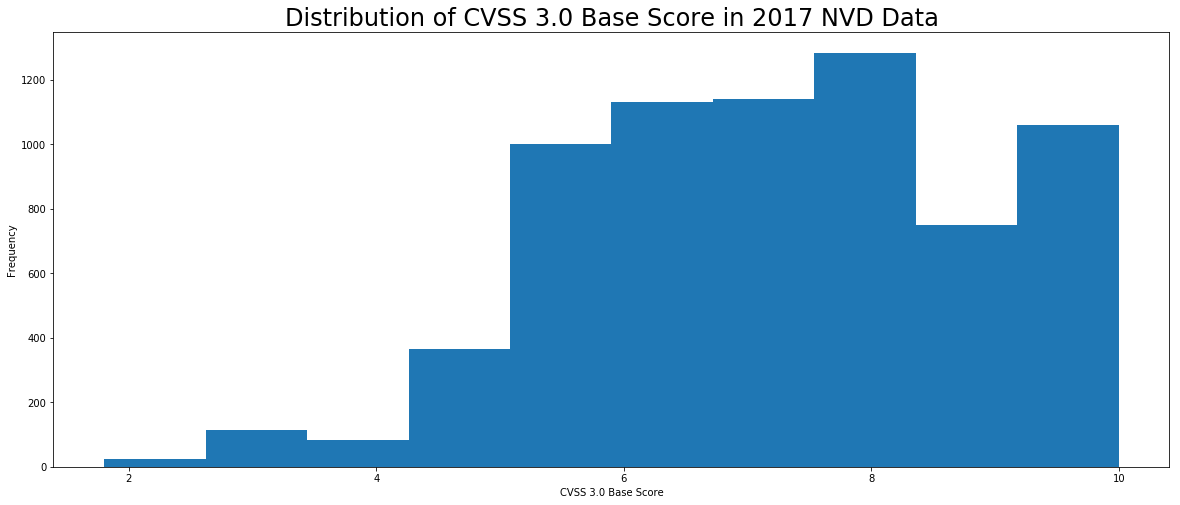

In [45]:
df_w_CWE_defs_cleaned["impact.baseMetricV3.cvssV3.baseScore"].plot(kind = "hist", figsize = (20,8))
plt.title("Distribution of CVSS 3.0 Base Score in 2017 NVD Data", fontsize = 24)
plt.xlabel('CVSS 3.0 Base Score');

Below I have plotted the frequency of a primary CWE code against the mean base CVSS 3.0 score associated with it. It is hard to identify any trends, because the mean CVSS score fluctuates so much, and as one moves to the far right of the x-axis, the score is potentially just the results of outliers having an huge impact because of the small sample size.

In [46]:
# Creating a variable to count primary CWE codes.
CWE_1_count = df_w_CWE_defs_cleaned.groupby(["CWE Code 1"]).count()["CVE ID"].sort_values(ascending=False)

In [47]:
# Extracting the mean base CVSS 3.0 score for each CWE code.
CWE_1_base = df_w_CWE_defs_cleaned.groupby(["CWE Code 1"]).mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

In [48]:
# Concatenating the two series together for use in graphic below
CWE_1_summary = pd.concat([CWE_1_count, CWE_1_base], axis=1, sort=True)

In [49]:
# Renaming columns to allow for easier analysis.
CWE_1_summary = CWE_1_summary.rename(columns={'CVE ID': 'Count', 'impact.baseMetricV3.cvssV3.baseScore': 'CVSS 3.0 Score'})

In [50]:
# Sorting by frequncy of CWE appearance
CWE_1_summary = CWE_1_summary.sort_values(by=['Count'], ascending=False)

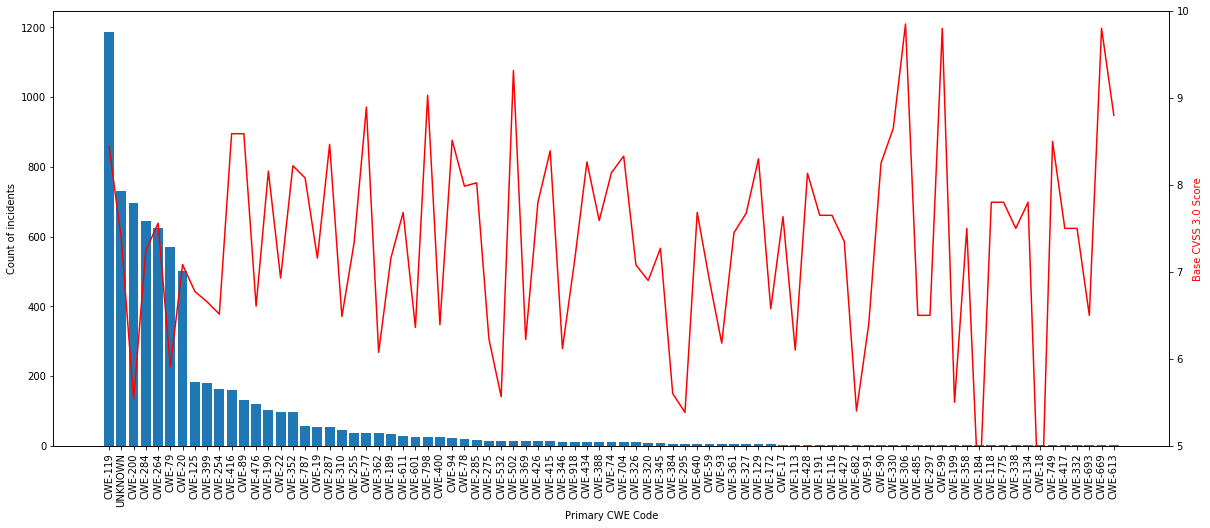

In [51]:
fig, ax1 = plt.subplots(figsize = (20,8))

ax2 = ax1.twinx()
ax1.bar(CWE_1_summary.index, CWE_1_summary["Count"])
ax2.plot(CWE_1_summary.index, CWE_1_summary["CVSS 3.0 Score"], 'red')

ax1.set_xlabel('Primary CWE Code')
ax1.set_ylabel('Count of incidents')
ax2.set_ylabel('Base CVSS 3.0 Score', color='red')
ax2.set_ylim(bottom = 5, top = 10)
    
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
plt.show()

** Note: CVSS score scale is only from 5-10 **

I used this [stackoverflow](https://stackoverflow.com/questions/14762181/adding-a-y-axis-label-to-secondary-y-axis-in-matplotlib) post for assistance in plotting the second axis, and [this one](https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib) for changing the orientation of the x-label text in this graph and for the one below.

Additionally, I will conduct the same analysis for secondary CWE codes as I did with the primary ones.

In [52]:
CWE_2_count = df_w_CWE_defs_cleaned.groupby(["CWE Code 2"]).count()["CVE ID"].sort_values(ascending=False)

In [53]:
CWE_2_base_CVSS = df_w_CWE_defs_cleaned.groupby(["CWE Code 2"]).mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

In [54]:
CWE_2_summary = pd.concat([CWE_2_count, CWE_2_base_CVSS], axis=1, sort=True)

In [55]:
CWE_2_summary = CWE_2_summary.rename(columns={'CVE ID': 'Count', 'impact.baseMetricV3.cvssV3.baseScore': 'CVSS 3.0 Score'})

In [56]:
CWE_2_summary = CWE_2_summary.sort_values(by=['Count'], ascending=False)

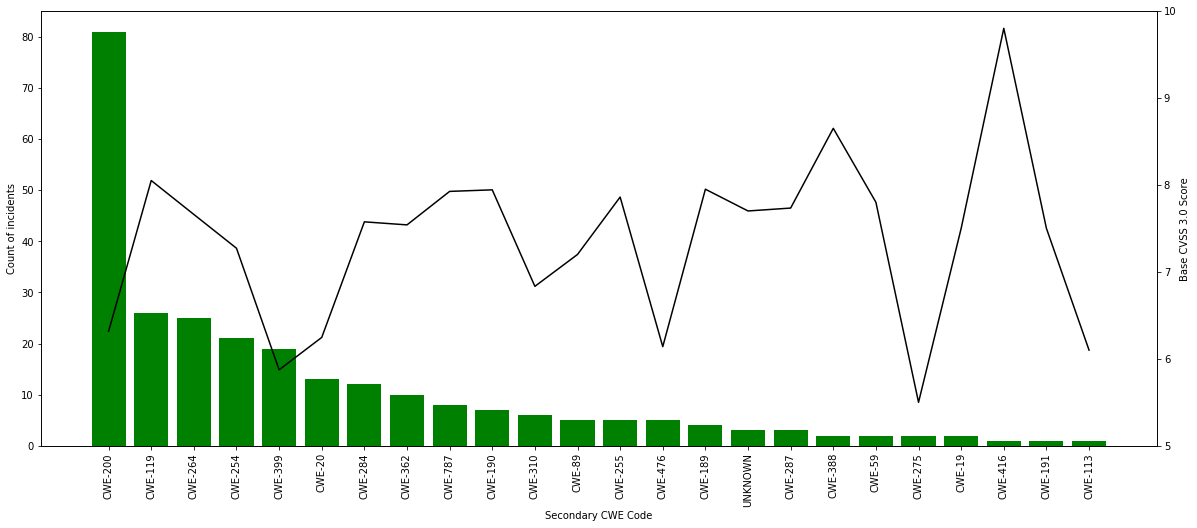

In [57]:
fig, ax1 = plt.subplots(figsize = (20,8))

ax2 = ax1.twinx()
ax1.bar(CWE_2_summary.drop("NONE").index, CWE_2_summary.drop("NONE")["Count"], color ='green')
ax2.plot(CWE_2_summary.drop("NONE").index, CWE_2_summary.drop("NONE")["CVSS 3.0 Score"], color = 'black')

# I have dropped all CWE codes of "NONE" above, as this represents the vast majority of secondary CWE entries

ax1.set_xlabel('Secondary CWE Code')
ax1.set_ylabel('Count of incidents')
ax2.set_ylabel('Base CVSS 3.0 Score')
ax2.set_ylim(bottom = 5, top = 10)
    
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
plt.show()

** Note: CVSS score scale is only from 5-10 **

There does not appear to be any trend with regard to incident count and CVSS score, so, going forward, I am going to use an admittedly arbitrary cutoff of at least 100 recorded incidents in 2017 for my analysis of the relative severity associated with various CWE codes.

In [58]:
# Recording the number of times each CWE code appears
df_incident_counts = ((df_w_CWE_defs_cleaned.groupby("CWE Code 1").count())["CVE ID"]).to_frame()

In [59]:
# Renaming columns for easier analysis
df_incident_counts = df_incident_counts.rename(columns={"CVE ID": "CWE Count"})

In [60]:
# Merging the CWE counts with the original clean data frame
df_w_CWE_defs_counts = df_w_CWE_defs_cleaned.merge(df_incident_counts, how="left", on="CWE Code 1")

In [61]:
# Isolating only those CWE codes for which there were 100 or more events
df_sig_CWE = df_w_CWE_defs_counts[df_w_CWE_defs_counts["CWE Count"]>99]

In [62]:
df_sig_CWE.groupby("CWE Code 1").mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

CWE Code 1
CWE-416    8.588679
CWE-89     8.587879
CWE-119    8.441414
CWE-190    8.157843
CWE-264    7.559040
UNKNOWN    7.372814
CWE-284    7.245652
CWE-20     7.083200
CWE-125    6.774863
CWE-399    6.655556
CWE-476    6.605882
CWE-254    6.514110
CWE-79     5.908757
CWE-200    5.538218
Name: impact.baseMetricV3.cvssV3.baseScore, dtype: float64

For all of the CWE codes that appear 100 times or more, it seems that the three with the highest mean CVSS scores are CWE-416, -89, and -119 (previously discussed). I will examine the first two below.

#### CWE-416

In [63]:
CWE_416_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-416"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_416_info[0])
print(CWE_416_info[1])
print(CWE_416_info[2])

CWE-416
Use After Free
Referencing memory after it has been freed can cause a program to crash, use unexpected values, or execute code.


Such "errors sometimes have no effect and other times cause a program to crash. While it is technically feasible for the freed memory to be re-allocated and for an attacker to use this reallocation to launch a buffer overflow attack, we are unaware of any exploits based on this type of attack," according to the [Open Web Application Security Project](https://www.owasp.org/index.php/Using_freed_memory). Thus, they appear to be primarily a nuisance that can lead to reduced productivity for enterprises.

#### CWE-89

In [64]:
CWE_89_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-89"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_89_info[0])
print(CWE_89_info[1])
print(CWE_89_info[2])

CWE-89
SQL Injection
The software constructs all or part of an SQL command using externally-influenced input from an upstream component, but it does not neutralize or incorrectly neutralizes special elements that could modify the intended SQL command when it is sent to a downstream component.


The [InfoSec Institute](https://resources.infosecinstitute.com/how-to-fix-the-top-five-cyber-security-vulnerabilities/#gref) provides some great information on this type of vulnerability and how to mitigate it:
    
"SQL Injection vulnerabilities are the most common flaws exploited in injection attacks. The attackers operate by providing input data to a web application that is then used in SQL queries. The data in the majority of cases comes from an untrusted input such as a web form, but it is a good practice to consider not trusted data and also data provided by the database. A common error made by developers is to trust data from their own database. However, there are several ways to poison these data and trigger a SQL injection vulnerability by using data in input extracted from the database."

# Part 3 - Unsupervised learning analysis using k-means clustering

During the final section of this project, I am going to use an unsupervised learning technique called k-means clustering in an effort to identify groups of vulnerabilities in the database that might have common characteristics.

An excellent summary of the mathematical basis for k-means clustering is available from the paper “[An Efficient k-Means Clustering Algorithm: Analysis and Implementation](http://www.cs.umd.edu/~mount/Papers/pami02.pdf)," by Tapas Kanungo, David M. Mount, Nathan S. Netanyahu, Christine D. Piatko, Ruth Silverman, and Angela Y. Wu:

"In k-means clustering, we are given a set of n data points in d-dimensional space R^d and an integer k and the problem is to determine a set of k points in Rd, called centers, so as to minimize the mean squared distance from each data point to its nearest center."

In the words of two other researchers, however, k-means clustering is "[sensitive to noisy data and outliers](http://www.math.uconn.edu/~gan/ggpaper/gan2017kmor.pdf)." Extreme values for a small number of data points can thus have an outsized impact on the location of a cluster's centroid in k-means clustering, and we want to ensure that the clusters are not abnormally distorted. Thanksfully, in the case of NVD data, this is not a problem. Although we have seen that the CVSS 3.0 base scores are not normally distributed, they are partially normalized due to the fact that they are ranked on a 0-10 scale. Furthermore, each incident has a small (3-4 value) range of possible different categorical values. Because of these characteristics of the dataset, the NVD is thus a good candidate for analysis using k-means clustering.

In order to implement this algorithm practically, I am going to import scikit-learn, a common machine learning library for Python, specifically using the "KMeans" function.

In [65]:
from sklearn.cluster import KMeans

I will also import the necessary tools from scikit-learn to conduct a [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) of my various clustering options. Essentially, the silhouette analysis will allow me to judge how many clusters are appropriate by evaluating the relative separation of the clusters in various scenarios.

In [66]:
from sklearn.metrics import silhouette_samples, silhouette_score

Finally, I have borrowed almost all of the below code block from this [GitHub post](https://github.com/udacity/machine-learning/pull/331/commits/bf0c698fb064620e05d7b723fee26dbd4fde9b9e) in order to build a function to determine the "clustering error" to assist in my silhouette analysis.

In [67]:
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

Moving into the data, I am going to drop the CWE code names ("CWE Code 1 Name" and "CWE Code 2 Name") and descriptions ("CWE Code 1 Description" and "CWE Code 2 Description") for the data set I will analyze, since they are so long and correspond directly with the CWE codes in any case. Aditionally, I am going to drop all remaining entries related to the CVSS 2.0 standard, as I will be relying on the 3.0 standard for my analysis. Finally, I will also drop the version number of the CVSS score, since it is the same throughout.

In [68]:
feature_analysis = df_w_CWE_defs_cleaned.drop(["CVE ID","CWE Code 1 Name",
                                               "CWE Code 2 Name",
                                               "CWE Code 1 Description",
                                               "CWE Code 2 Description",
                                               "impact.baseMetricV2.cvssV2.accessComplexity",
                                               "impact.baseMetricV2.cvssV2.accessVector",
                                               "impact.baseMetricV2.cvssV2.authentication",
                                               "impact.baseMetricV2.cvssV2.availabilityImpact",
                                               "impact.baseMetricV2.cvssV2.baseScore",
                                               "impact.baseMetricV2.cvssV2.confidentialityImpact",
                                               "impact.baseMetricV2.cvssV2.integrityImpact",
                                               "impact.baseMetricV2.cvssV2.version",
                                               "impact.baseMetricV2.exploitabilityScore",
                                               "impact.baseMetricV2.impactScore",
                                               "impact.baseMetricV2.obtainAllPrivilege",
                                               "impact.baseMetricV2.obtainOtherPrivilege",
                                               "impact.baseMetricV2.obtainUserPrivilege",
                                               "impact.baseMetricV2.severity",
                                               "impact.baseMetricV2.userInteractionRequired",
                                               "impact.baseMetricV3.cvssV3.version"], axis=1)

Now that I have a clean data set, I will create dummy variables for all of the various remaining features. Dummy variables turn categorical variables such as the CVSS 3.0 description for severity - which has LOW, HIGH, and CRITICAL values - into several numerical ones. Otherwise, my machine learning analysis would not be able to interpret this type of data.

In [69]:
feature_analysis = pd.get_dummies(feature_analysis)

In [70]:
feature_analysis = feature_analysis.apply(pd.to_numeric, errors='coerce')
# Ensuring that all the outputs are numeric values

In [71]:
feature_analysis.head()

,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,impact.baseMetricV3.cvssV3.attackComplexity_HIGH,impact.baseMetricV3.cvssV3.attackComplexity_LOW,impact.baseMetricV3.cvssV3.attackVector_ADJACENT_NETWORK,impact.baseMetricV3.cvssV3.attackVector_LOCAL,impact.baseMetricV3.cvssV3.attackVector_NETWORK,impact.baseMetricV3.cvssV3.attackVector_PHYSICAL,impact.baseMetricV3.cvssV3.availabilityImpact_HIGH,impact.baseMetricV3.cvssV3.availabilityImpact_LOW,impact.baseMetricV3.cvssV3.availabilityImpact_NONE,impact.baseMetricV3.cvssV3.baseSeverity_CRITICAL,impact.baseMetricV3.cvssV3.baseSeverity_HIGH,impact.baseMetricV3.cvssV3.baseSeverity_LOW,impact.baseMetricV3.cvssV3.baseSeverity_MEDIUM,impact.baseMetricV3.cvssV3.confidentialityImpact_HIGH,impact.baseMetricV3.cvssV3.confidentialityImpact_LOW,impact.baseMetricV3.cvssV3.confidentialityImpact_NONE,impact.baseMetricV3.cvssV3.integrityImpact_HIGH,impact.baseMetricV3.cvssV3.integrityImpact_LOW,impact.baseMetricV3.cvssV3.integrityImpact_NONE,impact.baseMetricV3.cvssV3.privilegesRequired_HIGH,impact.baseMetricV3.cvssV3.privilegesRequired_LOW,impact.baseMetricV3.cvssV3.privilegesRequired_NONE,impact.baseMetricV3.cvssV3.scope_CHANGED,impact.baseMetricV3.cvssV3.scope_UNCHANGED,impact.baseMetricV3.cvssV3.userInteraction_NONE,impact.baseMetricV3.cvssV3.userInteraction_REQUIRED,CWE Code 1_CWE-113,CWE Code 1_CWE-116,CWE Code 1_CWE-118,CWE Code 1_CWE-119,CWE Code 1_CWE-125,CWE Code 1_CWE-129,CWE Code 1_CWE-134,CWE Code 1_CWE-17,CWE Code 1_CWE-172,CWE Code 1_CWE-18,CWE Code 1_CWE-184,CWE Code 1_CWE-189,CWE Code 1_CWE-19,CWE Code 1_CWE-190,CWE Code 1_CWE-191,CWE Code 1_CWE-199,CWE Code 1_CWE-20,CWE Code 1_CWE-200,CWE Code 1_CWE-22,CWE Code 1_CWE-254,CWE Code 1_CWE-255,...,CWE Code 1_CWE-59,CWE Code 1_CWE-601,CWE Code 1_CWE-611,CWE Code 1_CWE-613,CWE Code 1_CWE-640,CWE Code 1_CWE-669,CWE Code 1_CWE-682,CWE Code 1_CWE-693,CWE Code 1_CWE-704,CWE Code 1_CWE-74,CWE Code 1_CWE-749,CWE Code 1_CWE-77,CWE Code 1_CWE-775,CWE Code 1_CWE-78,CWE Code 1_CWE-787,CWE Code 1_CWE-79,CWE Code 1_CWE-798,CWE Code 1_CWE-89,CWE Code 1_CWE-90,CWE Code 1_CWE-91,CWE Code 1_CWE-918,CWE Code 1_CWE-93,CWE Code 1_CWE-94,CWE Code 1_CWE-99,CWE Code 1_UNKNOWN,CWE Code 2_CWE-113,CWE Code 2_CWE-119,CWE Code 2_CWE-189,CWE Code 2_CWE-19,CWE Code 2_CWE-190,CWE Code 2_CWE-191,CWE Code 2_CWE-20,CWE Code 2_CWE-200,CWE Code 2_CWE-254,CWE Code 2_CWE-255,CWE Code 2_CWE-264,CWE Code 2_CWE-275,CWE Code 2_CWE-284,CWE Code 2_CWE-287,CWE Code 2_CWE-310,CWE Code 2_CWE-362,CWE Code 2_CWE-388,CWE Code 2_CWE-399,CWE Code 2_CWE-416,CWE Code 2_CWE-476,CWE Code 2_CWE-59,CWE Code 2_CWE-787,CWE Code 2_CWE-89,CWE Code 2_NONE,CWE Code 2_UNKNOWN
0,7.3,1.3,5.9,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,7.8,1.8,5.9,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5.5,1.8,3.6,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,5.5,1.8,3.6,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,5.0,1.3,3.6,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


My next task is to determine how many clusters I should use in order to best classify my data. For my analysis, I have arbitrarily chosen a value of 10 for the maximum number of clusters to evaluate. Attempting to analyze all possible numbers of clusters from 2 to 15,067 (total number of valid NVD entries for 2017) would be prohibitve in terms of computing power. Even breaking that range into "steps" would take an inordinate amount of time, and thus, I have settled on 10 as a reasonable option.

The following four code blocks were all derived from Udacity's [Machine Learning Engineer nanodegree program](https://www.udacity.com/course/machine-learning-engineer-nanodegree--nd009t), specifically the "k-means clustering mini-project."

In [72]:
possible_k_values = range(2, 11, 1)

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, feature_analysis) for k in possible_k_values]

In [73]:
# Display all of the possible k values and associated errors
list(zip(possible_k_values, errors_per_k))

[(2, 0.35974812806121476),
 (3, 0.317387502621869),
 (4, 0.32340305825756166),
 (5, 0.3377486238746929),
 (6, 0.35973171161684464),
 (7, 0.33524906923330816),
 (8, 0.33661379515403683),
 (9, 0.3423342550584388),
 (10, 0.34744748695009686)]

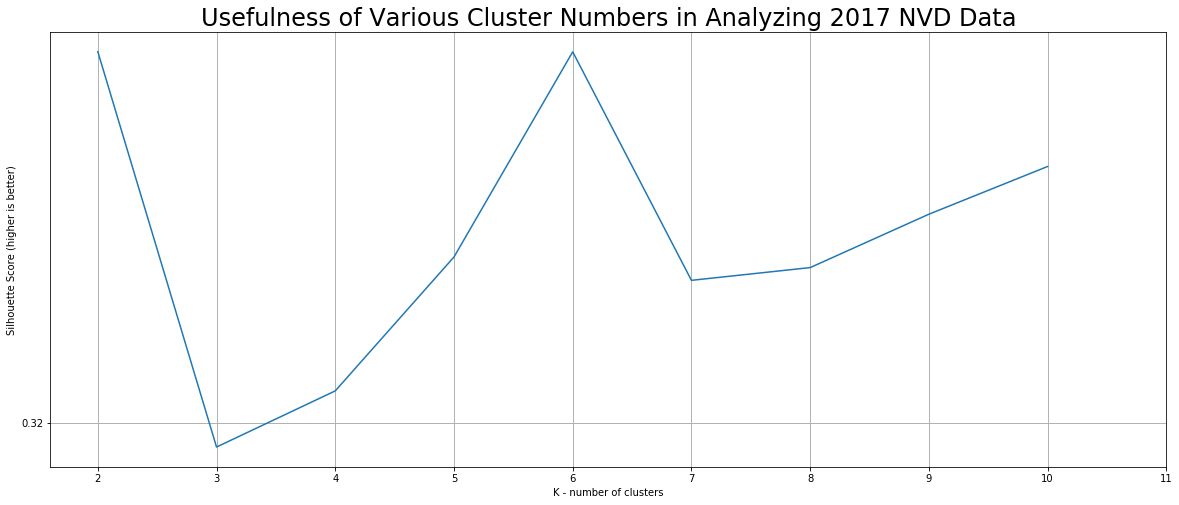

In [74]:
# Plotting the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)
plt.title("Usefulness of Various Cluster Numbers in Analyzing 2017 NVD Data", fontsize = 24)

# Labeling the chart and creating the grid/tick lines
xticks = np.arange(min(possible_k_values), max(possible_k_values)+2, 1)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

The silhouette score peaks with 2 and 6 clusters. Since I am trying to achieve the greatest analytical fidelity while still providing actionable results, I will select 6 clusters for my analysis.

### Building the 6-cluster model

In [75]:
# Initializing my model with number of clusters and setting the random state
kmeans_6 = KMeans(n_clusters = 6, random_state = 42)
predictions_clusters = kmeans_6.fit_predict(feature_analysis)

In [76]:
np.unique(predictions_clusters, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([ 551, 2175,  961,  718, 1116, 1437]))

In [77]:
predictions_clusters

array([1, 1, 5, ..., 3, 3, 3], dtype=int32)

In [78]:
predictions_clusters = predictions_clusters + 1
# Adding one to the cluster numbers so there is no "zero-th" cluster

In [79]:
# Turning the predictions into a data frame for later use
df_predicted_clusters = pd.DataFrame(predictions_clusters)
df_predicted_clusters = df_predicted_clusters.rename(columns={0: "Cluster"})

In [80]:
df_predicted_clusters["Cluster"].value_counts().sort_index()

1     551
2    2175
3     961
4     718
5    1116
6    1437
Name: Cluster, dtype: int64

Cluster 2 appears to include substantially more points than all of the other clusters, interestingly. I will now join the predicted cluster of each incident back onto my original cleaned data frame, and then evaluate the mean CVSS 3.0 score for each cluster.

In [81]:
df_CWE_clusters = df_w_CWE_defs_cleaned.join(pd.DataFrame(df_predicted_clusters))

In [82]:
df_CWE_base_CVSS = df_CWE_clusters.groupby("Cluster").mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

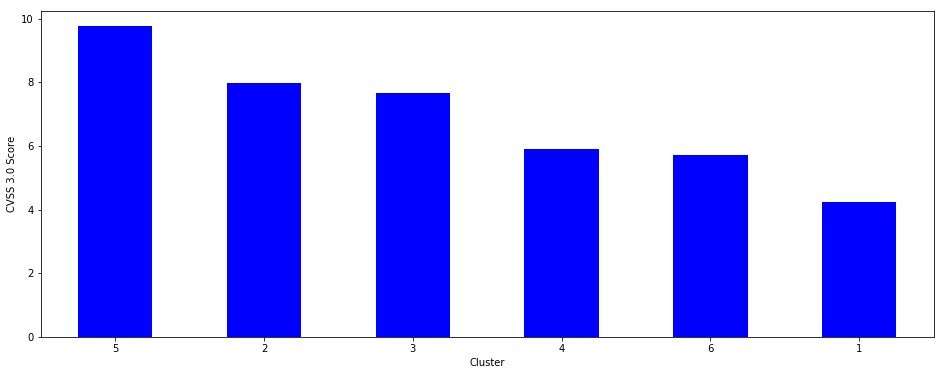

In [83]:
fig = df_CWE_base_CVSS.plot(kind="bar", figsize = (16,6), color = "b")
fig.set_ylabel('CVSS 3.0 Score');

for tick in fig.get_xticklabels():
    tick.set_rotation(0)

Cluster 5 has the highest mean CVSS 3.0 base score, and thus contains the overall most dangerous cybersecurity vulnerabilities. Drilling down further, however, I will plot the NVD entries in a 2-dimensional space, with the x-axis representing the vulnerabilities CVSS 3.0 exploitability score, and the y-axis representing its equivalent impact score. The highest-risk vulnerabilities are those with the greatest impact AND exploitability, thus I will pay special attention to the "top right" corner of the graph. I will further color code each point by cluster to determine if I can detect any useful trends from the analysis I performed previously.

It is important to note that the clustering is done based more than just the CVSS 3.0 impact and exploitability scores; the algorithm incorporates all off the numerical and categorical features found in the feature_analysis data frame. Since it is difficult to visualize more than two dimensions, however, I will use impact and exploitability as the two relevant axes.

In [84]:
colors_clusters = list(np.sort(df_CWE_clusters['Cluster'].unique()))
# Creating a variable 'colors' and putting it into numerical order to facilitate the plotting below
colors_clusters

[1, 2, 3, 4, 5, 6]

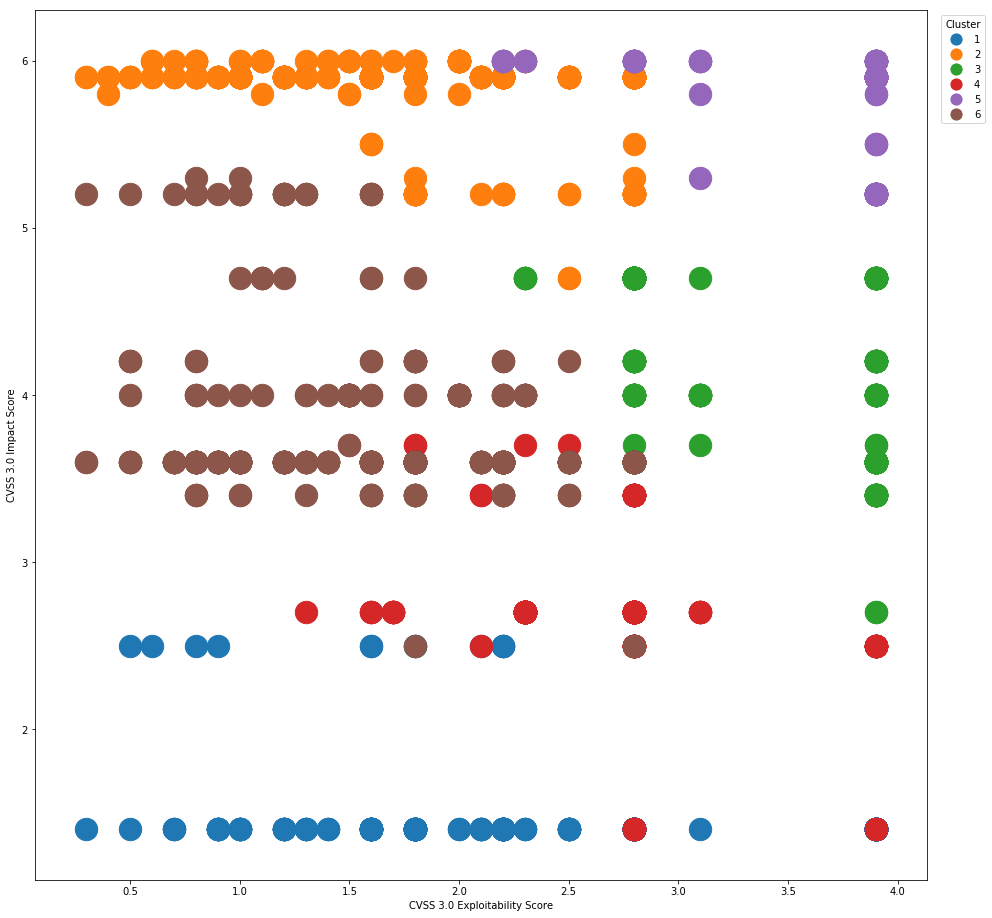

In [85]:
plt.figure(figsize=(16, 16))
plt.xlabel('CVSS 3.0 Exploitability Score')
plt.ylabel('CVSS 3.0 Impact Score')
colors_clusters = list(np.sort(df_CWE_clusters['Cluster'].unique()))
for i in range(len(colors_clusters)):
    data = df_CWE_clusters.loc[df_CWE_clusters["Cluster"] == colors_clusters[i]]
    plt.scatter("impact.baseMetricV3.exploitabilityScore", "impact.baseMetricV3.impactScore", s = 500, data = data, label = colors_clusters[i])

leg = plt.legend(markerscale = 0.5, title = "Cluster", loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
plt.show()

Because there is exact overlap in terms of the plotted location of a substantial number of points, I have set the opacity of each point to 10%. Furthermore, I have added an element of randomness to the plotted values called "jitter," in order to better understand potential trends. I used this [post](https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot) to learn how to implement the random jitter.

In [86]:
def rand_jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

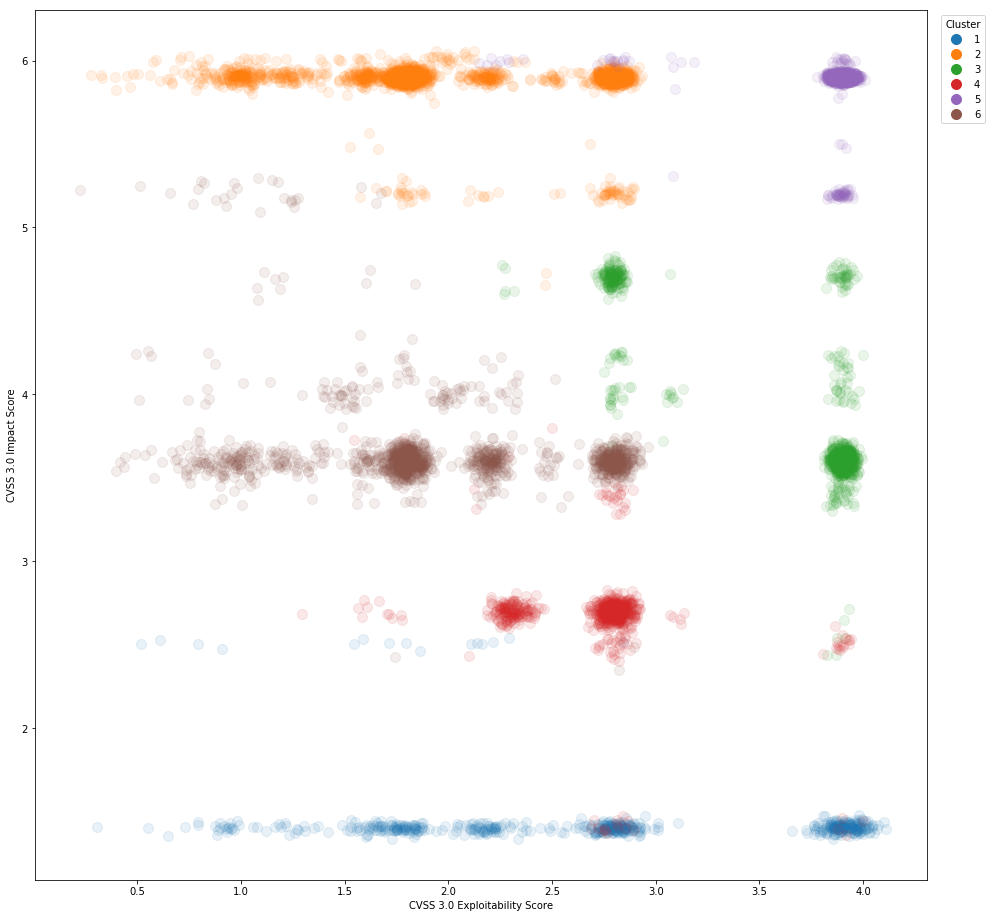

In [87]:
plt.figure(figsize=(16, 16))
plt.xlabel('CVSS 3.0 Exploitability Score')
plt.ylabel('CVSS 3.0 Impact Score')
colors_clusters = list(np.sort(df_CWE_clusters['Cluster'].unique()))
for i in range(len(colors_clusters)):
    data = df_CWE_clusters.loc[df_CWE_clusters["Cluster"] == colors_clusters[i]]
    # Adding random jitter
    data["impact.baseMetricV3.exploitabilityScore"] = rand_jitter(data["impact.baseMetricV3.exploitabilityScore"])
    data["impact.baseMetricV3.impactScore"] = rand_jitter(data["impact.baseMetricV3.impactScore"])
    # Plotting the jittered points.
    plt.scatter("impact.baseMetricV3.exploitabilityScore", "impact.baseMetricV3.impactScore", s = 100, alpha = 0.1, cmap = "set1", data=data, label=colors_clusters[i])

leg = plt.legend(markerscale = 1, title = "Cluster", loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles:
    lh.set_alpha(1)
    
plt.show()

The unsupervised learning algorithm seems to have done its job, creating several distinct groups of vulnerabilities which are easily distinguishable by their relative impact and exploitability.

## Part 4 - CVE-2017-5638: the vulnerability used in the Equifax hack

Since I mentioned the Equifax hack as a prime example of the dangers of leaving vulnerabilities unaddressed, I will wrap up this project by examining the actual NVD incident responsible for the breach. According to [press reporting](https://www.forbes.com/sites/thomasbrewster/2017/09/14/equifax-hack-the-result-of-patched-vulnerability/#256f36775cda), it was by exploiting [CVE-2017-5638](https://nvd.nist.gov/vuln/detail/CVE-2017-5638) that the hackers infiltrated Equifax's networks.

In [88]:
CVE_Equifax = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CVE ID"]=="CVE-2017-5638"]
CVE_Equifax

,CVE ID,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,CWE Code 1,CWE Code 2,CWE Code 1 Name,CWE Code 1 Description,CWE Code 2 Name,CWE Code 2 Description
6687,CVE-2017-5638,LOW,NETWORK,NONE,COMPLETE,10.0,COMPLETE,COMPLETE,2.0,10.0,10.0,False,False,False,HIGH,False,LOW,NETWORK,HIGH,10.0,CRITICAL,HIGH,HIGH,NONE,CHANGED,NONE,3.0,3.9,6.0,CWE-20,NONE,Input Validation,The product does not validate or incorrectly v...,NaN,NaN


In [89]:
CWE_Equifax = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-20"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_Equifax[0])
print(CWE_Equifax[1])
print(CWE_Equifax[2])

CWE-20
Input Validation
The product does not validate or incorrectly validates input that can affect the control flow or data flow of a program.


Input validation - a relatively easily fixable vulnerability - appears to have been the Achilles' Heel that allowed hackers into Equifax's systems. Applying my model to the Equifax vulnerability, I made an interesting discovery:

In [90]:
df_CWE_clusters[df_CWE_clusters["CVE ID"]=="CVE-2017-5638"]["Cluster"]

6687    5
Name: Cluster, dtype: int32

It seems that the Equifax vulnerability, even though it has a less-frequently appearing CWE code, was in fact a member of cluster 5, which my model previously identified as containing the most dangerous cybersecurity vulnerabilities. Additionally, simply plotting of the vulnerability used in the Equifax hack is quite revealing and demonstrates how analysis of even a simple two-dimensional model should have triggered the company's security team to take more decisive action upon [learning about the existence of a vulnerability](https://gizmodo.com/equifax-was-warned-about-vulnerability-but-failed-to-pa-1819065186) in a public [US-CERT release](https://www.us-cert.gov/ncas/current-activity/2017/03/08/Apache-Software-Foundation-Releases-Security-Updates) from March 2017.

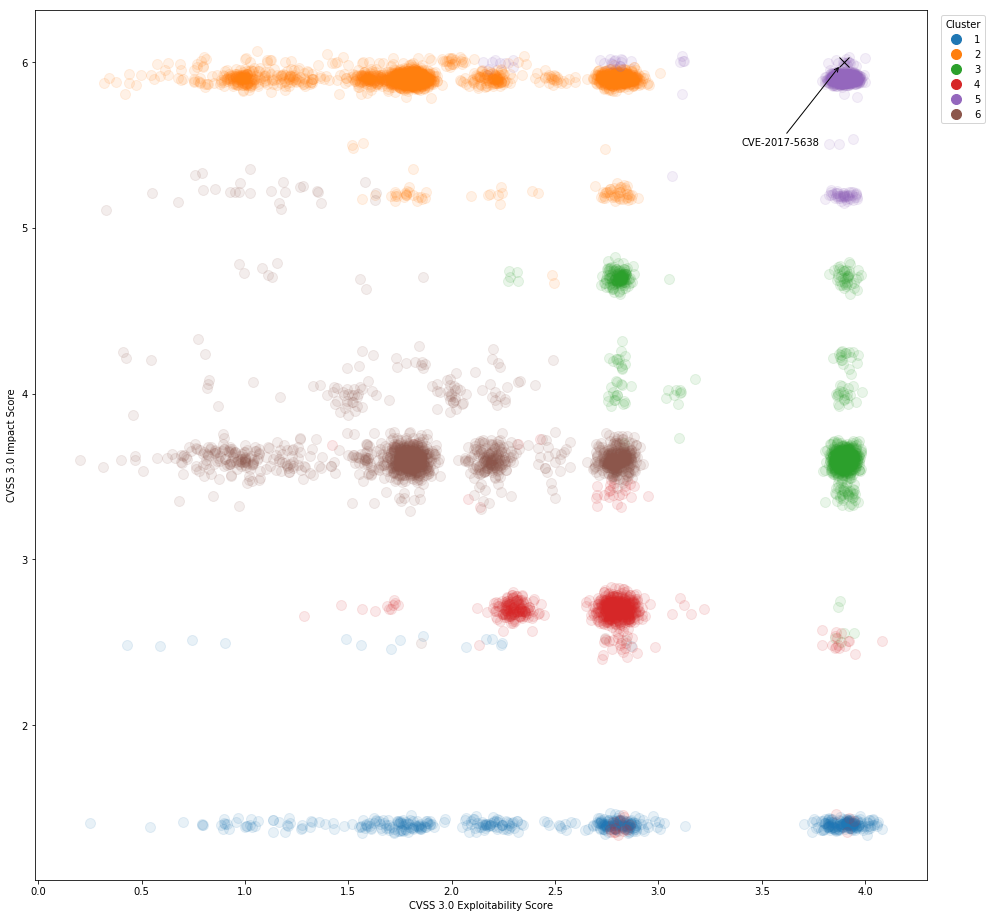

In [91]:
plt.figure(figsize=(16, 16))

plt.xlabel('CVSS 3.0 Exploitability Score')
plt.ylabel('CVSS 3.0 Impact Score')

cluster_colors = list(np.sort(df_CWE_clusters['Cluster'].unique()))

for i in range(len(colors_clusters)):
    data = df_CWE_clusters.loc[df_CWE_clusters["Cluster"] == colors_clusters[i]]
    # Adding random jitter
    data["impact.baseMetricV3.exploitabilityScore"] = rand_jitter(data["impact.baseMetricV3.exploitabilityScore"])
    data["impact.baseMetricV3.impactScore"] = rand_jitter(data["impact.baseMetricV3.impactScore"])
    # Plotting the jittered points.
    plt.scatter("impact.baseMetricV3.exploitabilityScore", "impact.baseMetricV3.impactScore", s = 100, alpha = 0.1, cmap = "tab30", data=data, label=colors_clusters[i])

leg = plt.legend(markerscale = 1, title = "Cluster", loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles: 
    lh.set_alpha(1)

#Plotting the Equifax vulnerability on the graphic
Equifax_X = CVE_Equifax["impact.baseMetricV3.exploitabilityScore"]
Equifax_Y = CVE_Equifax["impact.baseMetricV3.impactScore"]

plt.plot(Equifax_X, Equifax_Y, marker='x', markersize=10, color="black")
plt.annotate("CVE-2017-5638", color = "black", xy=(Equifax_X-.02, Equifax_Y-.02), xytext=(Equifax_X-.5, Equifax_Y-.5), arrowprops=dict(edgecolor="black", arrowstyle="->"))

plt.show();

## Part 5 - Conclusion

This analysis of the Equifax hack in particular and the NVD data in general does not suggest any earth-shattering conclusions. There are, however, important lessons to be learned and/or reinforced.

With regard to the Equifax hack, there is much to be said for senior leaders maintaining appropriate oversight over their organizations' cybersecurity posture, and following up on critical threats to it.  According to a [New York Times article](https://www.nytimes.com/2017/10/03/business/equifax-congress-data-breach.html) describing the incident and the Equifax CEO’s subsequent congressional testimony, after receiving the US-CERT alert, the company sent an internal email tasking its technical staff to address the CVE-2017-5638 vulnerability, but “an [unnamed] individual did not ensure communication got to the right person to manually patch the application.” Furthermore, software that Equifax used to detect software weaknesses failed to find the unpatched vulnerability in an automated and/or timely fashion.

In hindsight it is of course obvious that Equifax made a major mistake by not fixing a known vulnerability, but there are more granular takeaways to be had. Firstly, it is reasonably useful to model and identify the likely severity of vulnerabilities in the NVD. As seen from the preceeding analysis, it is possible to determine with some accuracy how severe a software flaw might be before experiencing an actual breach. If Equifax cybersecurity personnel identified that CVE-2017-5638 had characteristics similar to the most severe and exploitable of software vulnerabilities, they might have reacted differently. What is important to take away, however, is that junior leaders and individual contributors can and should use this type of threat modeling to help determine which incidents or vulnerabilities need attention immediately and which ones can wait.

With that said, however, senior leaders, especially of large organizations, cannot be expected to be involved in every software update, nor will they likely have the technical knowledge to identify the most important ones. They should, however, ensure that their subordinates provide them with a clear picture of the threat landscape and follow-up ruthlessly. Corporate and government leaders must exercise personal oversight over addressing the most dangerous potential vulnerabilities, rather than relying on automated systems or more junior, technically-minded staff to catch when they remain unpatched. As we have seen, the risks of failing to remain so engaged are quite high.

More generally, this analysis confirms quite a few commonly-held cybersecurity "rules of thumb." Primarily, many of the most impactful and exploitable vulnerabilities are quite common and easy for hackers to employ, especially buffer overflows, SQL injections, and poor credential management. Furthermore, as the k-means cluster analysis has shown, these vulnerabilities share some common characteristics with each other. Addressing the known universe of vulnerabilities will thus require greater discipline on the part of individual users, engineers, and leaders in order to identify and close the gaps through which hackers are most likely to enter computer networks. Renewed emphasis on this "low-hanging fruit" will likely allow for a greater return on investment for future cybersecurity efforts rather than dedicating resources towards addressing more complex but rare software flaws.

*The views expressed in this article are those of the author and do not reflect the official policy or position of the United States Government.*